# Here we'll train some models!

### Imports and Project Configuration

This cell sets up the notebook environment and loads configuration details required throughout the project.

### This cell:
- Imports standard and third-party libraries for:
  - Data handling: `pandas`, `numpy`
  - Modeling: `sklearn` (pipelines, preprocessing, linear models, metrics)
  - Visualization: `matplotlib`
  - Configuration parsing: `yaml`
- Loads project configuration files from the `conf/` directory:
  - `config.yaml` – overall project paths and settings
  - `variable_types.yaml` – defines column groups and data types
  - `cleaning_rules.yaml` – data cleaning and transformation rules
- Defines key directories and variables:
  - `PROJ`, `RAW_DIR`, `PROC_DIR` – base project paths
  - `numeric_cols` – list of numeric feature columns
- Ensures custom modules in `pipeline/` (for example, `AutoTransform`, `Winsorizer`) are importable.
- Silences `pandas` performance warnings for cleaner notebook output.

### Notes
- Paths are resolved relative to this notebook’s parent directory, so run this from within the `notebooks/` directory.

In [1]:
from __future__ import annotations

import json
import pathlib
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yaml
from optuna.importance import get_param_importances
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    ElasticNetCV,
    Lasso,
    LassoCV,
    LinearRegression,
    RidgeCV,
)
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler



# Project root and config files
PROJ = pathlib.Path().resolve().parent
CFG = yaml.safe_load(open(PROJ / "conf" / "config.yaml"))

# Variable types (numeric/categorical, etc.)
var_types = yaml.safe_load(open(PROJ / "conf" / "variable_types.yaml"))

# Data directories from config
RAW_DIR = PROJ / CFG["data"]["raw_dir"]
PROC_DIR = PROJ / CFG["data"]["processed_dir"]

# Convenience handle for numeric columns from variable types
numeric_cols = var_types["numeric_variables"]

# Cleaning rules
RULES = yaml.safe_load(open(PROJ / "conf" / "cleaning_rules.yaml"))

# Make project importable (so `pipeline.*` works)
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))

# Local project transformers (requires PROJ on sys.path above)
from pipeline.transformers import AutoTransform, Winsorizer  # noqa: E402


# Warnings / display setup
PerfWarn = pd.errors.PerformanceWarning
warnings.filterwarnings("ignore", category=PerfWarn)

# Data Loading and Train/Validation/Test Split

This cell loads the preprocessed CBECS dataset and prepares the modeling splits.

### What this cell does
- Reads the cleaned data file `cbecs_2018_clean.parquet` from the processed data directory defined in the configuration.
- Derives lists of categorical and numeric feature columns from `variable_types.yaml`, restricted to those present in the loaded DataFrame.
- Converts all categorical columns to `object` type to ensure consistent downstream handling by `sklearn` preprocessing steps.
- Defines features `X` and target variable `y` (`LOG_MFBTU` is the logged energy-use target).
- Performs an **80/10/10 split**:
  - 10% reserved for final test evaluation (`X_test`, `y_test`)
  - Remaining 90% split again into 10% validation and 80% training (`X_train`, `y_train`, `X_val`, `y_val`)
- Uses a fixed random seed (`rand = 1`) for reproducibility.
- Verifies that the splits collectively cover all rows in the dataset.

In [2]:
# First read in the file...
df = pd.read_parquet(PROC_DIR / "cbecs_2018_clean.parquet")  # load preprocessed data
cat_cols = [c for c in var_types["categorical_variables"] if c in df.columns]  # categorical cols present in df
num_cols = [c for c in var_types["numeric_variables"] if c in df.columns]      # numeric cols present in df

# Coerce all non-numeric columns to be astype object. Many are actually integers that refer to codes.
df[cat_cols] = df[cat_cols].astype(object)  # ensure consistent dtype for downstream encoders (e.g., OneHotEncoder)

# Assign X, y 
X = df.drop('LOG_MFBTU', axis=1)  # feature matrix (all columns except target)
y = df['LOG_MFBTU']               # target on log scale (assumed created upstream)

# Split the data into validation, train, and test sets
# e.g., 80/10/10 split
test_size = 0.10  # final hold-out fraction for unbiased evaluation
val_size  = 0.10  # desired validation fraction out of the full dataset
rand      = 1     # fixed seed for reproducibility

# 1) Hold out test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=rand, shuffle=True
)  # split off the test set first

# 2) From the remainder, carve out validation
val_rel = val_size / (1.0 - test_size)  # convert absolute val fraction (10%) into relative share of the remaining 90%
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_rel, random_state=rand, shuffle=True
)  # create validation split from the training pool

# Check and make sure the splits worked as expected...
df.shape  # quick visual confirmation of total rows/columns
check_shape = X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == df.shape[0]  # verify row counts add up

print(f"Split correctly: {check_shape}")  # True indicates the 80/10/10 partitioning sums to full dataset

Split correctly: True


# Baseline Benchmarks for model comparison

I add two deliberately simple benchmarks before training richer models to anchor expectations and prevent overclaiming.

1) Mean predictor (predict `mean(y_train)` for everyone).  
   - Why: This is the irreducible “do nothing” baseline. Any sensible model must beat it on validation/test; otherwise I'm fitting noise or leaking information.  
   - We compute the mean strictly from `y_train` to avoid contaminating evaluation with information not available at fit time.

2) One-feature linear regression on building size (`SQFT_log1p` by default).  
   - Why: Floor area is a first-order driver of energy use; if our pipeline can’t beat “energy ~ size” on held-out data, it’s unlikely to add value in practice. This is a more realistic benchmark than the mean because it encodes a core domain relationship.  
   - This establishes a practical reference that a multivariate model should surpass. It also gives an interpretable slope and intercept that help validate directionality and scaling.  

General notes:
- We evaluate on validation/test to avoid optimistic bias.  
- We report R², SSE, and MSE because they reveal different aspects: explanation power (R²), total squared error mass (SSE) for scale/context, and average error (MSE) for comparability.  
- If the one-feature model strongly outperforms the mean but the full model does not outperform the one-feature baseline, I likely have either over-regularization, noisy engineered features diluting signal, or preprocessing mismatches.

In [3]:
def baseline_with_sqft(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    feature="num__SQFT_log1p",
    print_lines=True,
    decimals=4,
):
    """
    Baselines:
      1) Predict mean(y_train)
      2) One-feature OLS using `feature`
    """

    # targets: 1D arrays; evaluate on test if provided, else train
    y_train = np.asarray(y_train).ravel()
    y_eval = y_train if y_test is None else np.asarray(y_test).ravel()
    n = int(y_eval.shape[0])

    # ---- Baseline 1: mean predictor ----
    yhat_mean_value = float(np.mean(y_train))
    yhat_mean = np.full_like(y_eval, fill_value=yhat_mean_value, dtype=float)
    r2_mean = r2_score(y_eval, yhat_mean)
    resid_mean = y_eval - yhat_mean
    sse_mean = float(np.sum(resid_mean**2))
    mse_mean = float(sse_mean / n)

    mean_results = {
        "yhat_mean": yhat_mean_value,
        "r2": r2_mean,
        "sse": sse_mean,
        "mse": mse_mean,
        "n": n,
    }

    # helper: return a single column as 2D array
    def _col2d(X, feat):
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()          # keep 2D
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]                  # keep 2D
        raise TypeError("For ndarray X, 'feature' must be an int; for DataFrame, a column name.")

    # ---- Baseline 2: one-feature LinearRegression ----
    Xtr_col = _col2d(X_train, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)

    Xev_col = Xtr_col if X_test is None else _col2d(X_test, feature)
    yhat_lr = lr.predict(Xev_col)
    r2_lr = r2_score(y_eval, yhat_lr)
    resid_lr = y_eval - yhat_lr
    sse_lr = float(np.sum(resid_lr**2))
    mse_lr = float(sse_lr / n)

    lr_results = {
        "r2": r2_lr,
        "sse": sse_lr,
        "mse": mse_lr,
        "coef": float(lr.coef_[0]),
        "intercept": float(lr.intercept_),
        "n": n,
    }

    results = {"mean": mean_results, "lr_one_feature": lr_results}

    if print_lines:
        d = decimals
        print(f"BASELINE mean: R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={n}")
        print(f"LR[{feature}]: coef={lr.coef_[0]:.{d}f}  intercept={lr.intercept_:.{d}f}  "
              f"R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={n}")

    return results

# example: evaluate on test with a size feature
results = baseline_with_sqft(X_train, y_train, X_test, y_test, feature="SQFT_log1p")

BASELINE mean: R2=-0.0075  SSE=2726.6586  MSE=4.2872  n=636
LR[SQFT_log1p]: coef=1.0556  intercept=3.4813  R2=0.8234  SSE=478.0188  MSE=0.7516  n=636


# Preprocessing pipelines and linear model benchmarks

This section builds separate preprocessing for numeric and categorical inputs, combines them with a `ColumnTransformer`, and evaluates several linear/regularized models using K-fold cross-validation.

Why this setup
- Wrapping preprocessing inside the model pipeline ensures the same transformations are applied consistently in each CV fold and later at inference.
- Comparing OLS, Ridge, Lasso, and Elastic Net reveals whether regularization helps and whether sparsity (L1) improves generalization.
- K-fold CV on the training set provides a fair, variance-reduced estimate of out-of-sample performance without touching the test set.

In [4]:
# Numeric pipeline:
# - SimpleImputer(median) handles missing numeric values (+ missingness indicators if desired).
# - StandardScaler standardizes numerics for models sensitive to feature scale.
num_pipe = Pipeline([
    ("median_imputer", SimpleImputer(strategy='median', add_indicator=True)),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
# - OneHotEncoder creates 0/1 indicator columns for categories.
# - handle_unknown="ignore" is safer for inference when unseen categories appear.
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer:
# - Routes numeric vs categorical columns to their respective pipelines.
# - Selectors are dtype-based, so no hard-coded column lists are needed.
# - remainder="drop" keeps the feature space controlled and reproducible.
preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_include=["object", "category", "bool"])),
    ],
    remainder="drop"
)

# Cross-validation setup:
# - KFold with shuffling and fixed random_state for reproducibility.
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Candidate linear models:
# - OLS (no regularization) as a reference.
# - Ridge (L2), Lasso (L1), ElasticNet (L1+L2) with internal CV to tune strength.
models = {
    "OLS": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 25), cv=5),
    "Lasso": LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4),
    "ElasticNet": ElasticNetCV(cv=5, n_jobs=-1, l1_ratio=[0.2, 0.5, 0.8],
                               max_iter=100_000, tol=1e-4, selection="cyclic", random_state=1),
}

for name, m in models.items():
    # Fresh preprocessing per model/fit:
    # clone(preproc) ensures a new, unfitted transformer graph inside each pipeline and CV split.
    pipe = Pipeline([("preproc", clone(preproc)), ("model", m)])
    # CV uses the full pipeline (preproc + model), preventing leakage of preprocessing across folds.
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1).mean()
    print(f"{name}: {score:.3f}")

OLS: -752703983480718592.000
Ridge: 0.924
Lasso: 0.925
ElasticNet: 0.925


# Repeated K-fold CV for Lasso vs Elastic Net

This section uses `RepeatedKFold` to get a more stable estimate of generalization for two pipelines (Lasso and Elastic Net), each wrapping the same preprocessing. Repeating K-fold reduces variance in CV estimates and helps detect small but consistent performance differences. I report the mean ± std R² across all folds/repeats and the average per-fold delta (ENet − Lasso) to quantify any advantage.

In [5]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)  # more stable CV via repeats

# Lasso pipeline (alpha tuned via internal CV)
lasso = Pipeline([
    ("preproc", clone(preproc)),                               # fresh, unfitted preproc per fit
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4))
])

# Elastic Net pipeline (alpha + l1_ratio tuned via internal CV)
enet = Pipeline([
    ("preproc", clone(preproc)),
    ("model", ElasticNetCV(cv=5, n_jobs=-1,
                           l1_ratio=[0.0001, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9999],
                           max_iter=100_000, tol=1e-4, selection="cyclic",
                           random_state=1))
])

# Cross-validated R² distributions across repeats/folds
s_lasso = cross_val_score(lasso, X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)
s_enet  = cross_val_score(enet,  X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)

# Summary: central tendency and dispersion; plus average per-fold improvement of ENet over Lasso
print(f"Lasso  mean={s_lasso.mean():.3f} ± {s_lasso.std():.3f}")
print(f"ENet   mean={s_enet.mean():.3f}  ± {s_enet.std():.3f}")
print(f"Δ(EN-Lasso) = {(s_enet - s_lasso).mean():.4f}")

Lasso  mean=0.924 ± 0.007
ENet   mean=0.924  ± 0.007
Δ(EN-Lasso) = -0.0000


# Nested CV for Lasso and a stable alpha

In this step, I run nested cross-validation to tune and stabilize the Lasso regularization strength:

- **Inner CV (`inner`)** tunes `alpha` within each outer split.  
- **Outer CV (`rkf`)** estimates generalization performance via `cross_validate`, returning a fitted estimator for each split.  
- I then extract the tuned `alpha` from each outer model and take the **median** as `alpha_star`, giving me a single, robust hyperparameter for refitting the final model.

### Why I chose Lasso (L1) instead of Elastic Net (L1 + L2)
I opted for Lasso for the following reasons:
- **Sparsity and interpretability:** Lasso produces a simpler model by setting some coefficients to zero, which helps identify which predictors matter most and makes model interpretation straightforward.  
- **Comparable performance:** In earlier repeated CV results, Elastic Net didn’t consistently outperform Lasso. Since both achieved similar R², I prefer the simpler regularization path.  
- **Lower tuning complexity:** Lasso requires tuning only one parameter (`alpha`), while Elastic Net adds an additional `l1_ratio`. Given the marginal performance difference, Lasso offers a cleaner workflow with fewer moving parts.  


### Notes
Nested CV helps avoid optimistic bias by separating hyperparameter tuning (inner loop) from performance estimation (outer loop).  
Using the median of the per-fold `alpha` values provides a stable central estimate and reduces sensitivity to any single fold’s peculiarities.

I'll pick Lasso as it's a simpler model and has fewer hyperparameters to tune. It also seems like there's essentially no performance benefit to choosing ENet. Now I'll do a finer tuning pass on the Lasso. 

In [6]:
inner = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

# Lasso pipeline with nested tuning: inner CV selects alpha per outer split
lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=inner, n_jobs=-1, max_iter=200_000, tol=1e-4, selection="cyclic"))  # higher max_iter for stable convergence
])

# Outer CV: evaluate generalization and keep fitted estimators (one per outer split)
out = cross_validate(
    lasso, X_train, y_train,
    cv=rkf,                        # outer folds from the previous cell
    scoring="r2",
    n_jobs=-1,
    return_estimator=True
)

# Collect tuned alphas from each outer-fit, then choose a robust central value
alphas = [est.named_steps["model"].alpha_ for est in out["estimator"]]
alpha_star = float(np.median(alphas))  # single, stable alpha for final refit

# Final Lasso fit and evaluation

At this point, I’m using the median `alpha_star` from nested CV to refit a final Lasso model on the full training data.  
This model represents my best regularized linear fit after all tuning and validation steps.

I then evaluate it on the **held-out test set** to get an unbiased measure of how well the model generalizes.

- Using the training set only for fitting ensures that the final metrics truly reflect out-of-sample performance.  
- Fixing `alpha` before this final fit locks in the hyperparameter choice and prevents any leakage from the test set.  
- The test evaluation (R², SSE, MSE) provides a final quantitative summary of model fit quality and residual magnitude.

In [7]:
# Final Lasso: refit on training data using the stable alpha from nested CV
final_lasso = Pipeline([
    ("preproc", clone(preproc)),                                        # fresh, unfitted preprocessing
    ("model", Lasso(alpha=alpha_star, max_iter=200_000, tol=1e-4,      # fixed regularization from CV
                    selection="cyclic"))
]).fit(X_train, y_train)                                               # fit only on train (test remains untouched)

# Predict on the held-out test set to obtain an unbiased performance estimate
y_pred = final_lasso.predict(X_test)

# Evaluate on test 
r2_test = r2_score(y_test, y_pred)
residuals = y_test - y_pred
sse = np.sum(residuals ** 2)              # total squared error on test
mse = sse / len(y_test)                   # average squared error

# Summary report
print(f"R²  = {r2_test:.4f}")
print(f"SSE = {sse:.4f}")
print(f"MSE = {mse:.4f}")

R²  = 0.9364
SSE = 172.0816
MSE = 0.2706


# Extracting feature names and coefficients

I want a tidy, interpretable view of the trained model’s coefficients aligned to the **post-preprocessing** feature space.  
Because the `ColumnTransformer` expands/renames columns (e.g., one-hot encoding), I first obtain the transformed feature names, then pair them with the Lasso coefficients.

This does the following:
- Ensures coefficient interpretation matches the actual design matrix used by the model.
- Makes sparsity explicit by flagging zero vs nonzero weights.
- Produces a sortable table to review the largest (absolute) effects and sanity-check directionality.

In [8]:
# grab steps
pre = final_lasso.named_steps["preproc"]
mod = final_lasso.named_steps["model"]

# 1) feature names after preprocessing
# Prefer the transformer’s native names; otherwise rebuild from the ColumnTransformer spec.
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # ---- Fallback for older sklearn: build names manually ----
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue  # nothing to add

        if trans == "passthrough":
            # keep original identifiers for passthrough features
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            feature_names.extend([str(c) for c in cols])
        else:
            # try transformer-provided names (e.g., OneHotEncoder expands categories)
            if hasattr(trans, "get_feature_names_out"):
                base = np.array(cols).astype(str)  # ensure string base names
                feature_names.extend(trans.get_feature_names_out(base))
            else:
                # last resort: prefix with transformer name to avoid collisions
                if isinstance(cols, (list, np.ndarray)):
                    feature_names.extend([f"{name}__{c}" for c in cols])
                else:
                    feature_names.append(f"{name}")

feature_names = np.asarray(feature_names)

# 2) coefficients aligned with transformed columns
coefs = mod.coef_.ravel()

# 3) tidy table: magnitude sorting highlights strongest effects; nonzero flags sparsity
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "nonzero": coefs != 0.0,  # Lasso zeroes → feature dropped
    }
).sort_values("abs_coef", ascending=False).reset_index(drop=True)

# top coefficients by absolute value
coef_df.head(10)

,feature,coef,abs_coef,nonzero
0,num__SQFT_log1p,1.333799,1.333799,True
1,cat__PBA_4,0.393964,0.393964,True
2,cat__PRHT1_1,-0.383009,0.383009,True
3,cat__PBA_6,0.321376,0.321376,True
4,cat__PBA_5,-0.288161,0.288161,True
5,cat__BOOSTWT_nan,-0.286047,0.286047,True
6,cat__ENRGYPLN_nan,-0.286012,0.286012,True
7,cat__WHRECOV_nan,-0.267166,0.267166,True
8,cat__NGUSED_1,0.210005,0.210005,True
9,cat__VAV_nan,-0.175660,0.175660,True


# Show lasso feature importance plot

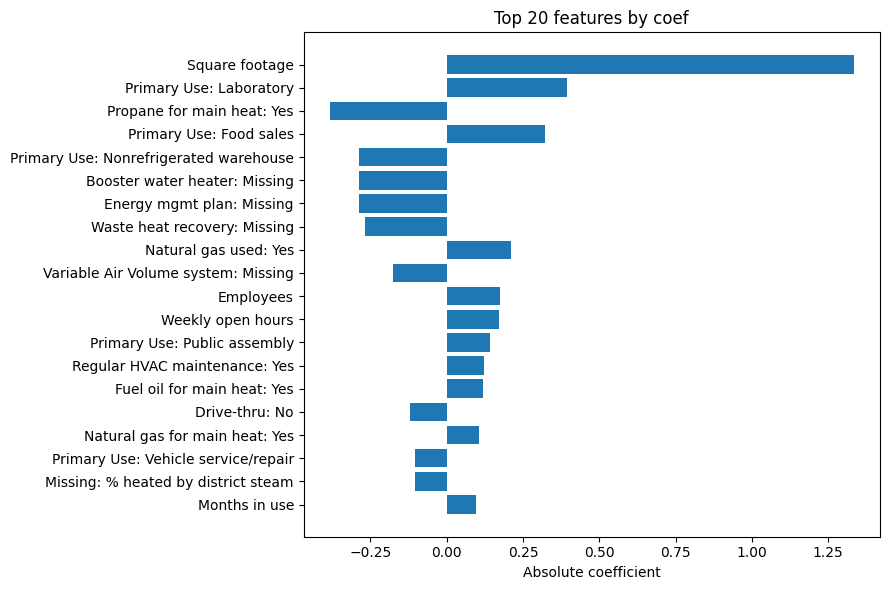

In [9]:
# Mapping from feature strings (your first 20) to readable labels
readable_map = {
    "num__SQFT_log1p": "Square footage",
    "cat__PBA_4": "Primary Use: Laboratory",
    "cat__PRHT1_1": "Propane for main heat: Yes",
    "cat__PBA_6": "Primary Use: Food sales",
    "cat__PBA_5": "Primary Use: Nonrefrigerated warehouse",
    "cat__BOOSTWT_nan": "Booster water heater: Missing",
    "cat__ENRGYPLN_nan": "Energy mgmt plan: Missing",
    "cat__WHRECOV_nan": "Waste heat recovery: Missing",
    "cat__NGUSED_1": "Natural gas used: Yes",
    "cat__VAV_nan": "Variable Air Volume system: Missing",
    "num__NWKER_log1p": "Employees",
    "num__WKHRS_sqrt": "Weekly open hours",
    "cat__PBA_13": "Primary Use: Public assembly",
    "cat__MAINT_1.0": "Regular HVAC maintenance: Yes",
    "cat__FKHT1_1": "Fuel oil for main heat: Yes",
    "cat__DRVTHRU_0.0": "Drive-thru: No",
    "cat__NGHT1_1": "Natural gas for main heat: Yes",
    "cat__PBAPLUS_46": "Primary Use: Vehicle service/repair",
    "num__missingindicator_STHWP_ST": "Missing: % heated by district steam",
    "num__MONUSE": "Months in use",
}

# Take first 20 rows from your existing coef_df
top20 = coef_df.head(20).copy()
top20["readable"] = top20["feature"].map(readable_map).fillna(top20["feature"])

# Bar plot of absolute coefficients
plt.figure(figsize=(9, 6))
y = np.arange(len(top20))
plt.barh(y, top20["coef"].values)
plt.yticks(y, top20["readable"].values)
plt.xlabel("Absolute coefficient")
plt.title("Top 20 features by coef")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

<!-- # Validation-set check: baselines vs final pipeline

I compare three models on the validation split, holding training information fixed:
1) **Baseline mean** — predicts `mean(y_train)` to set a floor.
2) **One-feature LR** — `y ~ SQFT_log1p` fit on train, evaluated on val; a domain-reasonable bar.
3) **Final Lasso pipeline** — already fit on train; evaluated on val for apples-to-apples comparison.

This confirms that the tuned pipeline improves over simple heuristics on unseen data and helps diagnose when a complex model fails to clear a strong univariate baseline. -->


In [10]:
# def evaluate_on_validation(
#     X_train, y_train, X_val, y_val, final_lasso, feature="num__SQFT_log1p", decimals=4
# ):
#     # --- helpers ---
#     def _col2d(X, feat):
#         # Return a single feature as 2D (n,1) for sklearn; supports DataFrame (by name) and ndarray (by index).
#         import pandas as pd, numpy as np
#         if isinstance(X, pd.DataFrame):
#             if feat not in X.columns:
#                 raise KeyError(f"Column '{feat}' not found in X.")
#             return X[[feat]].to_numpy()
#         X = np.asarray(X)
#         if isinstance(feat, (int, np.integer)):
#             return X[:, [feat]]
#         raise TypeError("For ndarray X, 'feature' must be an int index; for DataFrame X, a column name.")

#     def _metrics(y_true, y_pred):
#         # Compact metric helper to keep logic consistent across models.
#         resid = y_true - y_pred
#         sse = float(np.sum(resid**2))
#         mse = float(sse / len(y_true))
#         r2  = float(r2_score(y_true, y_pred))
#         return r2, sse, mse

#     # --- 1) Baseline mean (fit on train mean, eval on val) ---
#     y_train = np.asarray(y_train).ravel()
#     y_val   = np.asarray(y_val).ravel()
#     mean_val = float(y_train.mean())
#     yhat_mean = np.full_like(y_val, fill_value=mean_val, dtype=float)
#     r2_mean, sse_mean, mse_mean = _metrics(y_val, yhat_mean)

#     # --- 2) One-feature LinearRegression (fit on train, eval on val) ---
#     Xtr_col = _col2d(X_train, feature)
#     Xva_col = _col2d(X_val, feature)
#     lr = LinearRegression().fit(Xtr_col, y_train)
#     yhat_lr = lr.predict(Xva_col)
#     r2_lr, sse_lr, mse_lr = _metrics(y_val, yhat_lr)

#     # --- 3) Final Lasso pipeline (already fit on train), eval on val ---
#     yhat_lasso = final_lasso.predict(X_val)
#     r2_lasso, sse_lasso, mse_lasso = _metrics(y_val, yhat_lasso)

#     # --- pretty print ---
#     d = decimals
#     print(f"BASELINE mean        : R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={len(y_val)}")
#     print(f"LR[{feature}]        : R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={len(y_val)}  "
#           f"(coef={lr.coef_[0]:.{d}f}, intercept={lr.intercept_:.{d}f})")
#     print(f"Lasso (final pipeline): R2={r2_lasso:.{d}f}  SSE={sse_lasso:.{d}f}  MSE={mse_lasso:.{d}f}  n={len(y_val)}")

#     # --- return a tidy summary ---
#     summary = pd.DataFrame([
#         {"model": "baseline_mean", "R2": r2_mean,  "SSE": sse_mean,  "MSE": mse_mean},
#         {"model": f"LR[{feature}]", "R2": r2_lr,   "SSE": sse_lr,   "MSE": mse_lr,
#          "coef": float(lr.coef_[0]), "intercept": float(lr.intercept_)},
#         {"model": "lasso_final",    "R2": r2_lasso,"SSE": sse_lasso,"MSE": mse_lasso},
#     ])
#     return summary

# # ---- Example call ----
# summary_val = evaluate_on_validation(X_train, y_train, X_val, y_val, final_lasso, feature="SQFT_log1p")
# print(summary_val)

# Random Forest regressor

I’m adding a Random Forest as a nonlinear, interaction-capturing baseline for tabular data. It can model non-additive effects and segment heterogeneity without manual feature engineering.

Evaluation plan
- Keep preprocessing inside the pipeline to avoid leakage.
- Use repeated K-fold CV for a fair baseline.
- Do a small `RandomizedSearchCV` over depth, leaf size, and feature subsampling.
- Refit the best pipeline on the full training set and evaluate once on the held-out test set.

Key knobs
- `n_estimators` (ensemble size), `max_depth` (complexity), `min_samples_leaf` (regularization), `max_features` (decorrelation).

In [11]:
# --- 1) Baseline RF with sensible defaults, CV on train ---

rf_base = Pipeline([
    ("preproc", clone(preproc)),  # same preprocessing as Lasso
    ("model", RandomForestRegressor(
        n_estimators=500,         # stable baseline
        random_state=1,
        n_jobs=-1
    ))
])

# use existing repeated K-fold if defined
cv_rf = rkf  

scores = cross_val_score(rf_base, X_train, y_train, cv=cv_rf, scoring="r2", n_jobs=-1)
print(f"RF baseline R² (CV): mean={scores.mean():.3f} ± {scores.std():.3f}")

RF baseline R² (CV): mean=0.913 ± 0.008


# Hyperparameter tuning with Optuna (Random Forest and XGboost)

**What Optuna is:** a Bayesian/SMBO optimizer (TPE by default) that proposes hyperparameters, runs your objective (e.g., CV score), learns from results, and proposes better configs next.

**How I’ll use it here**
1. Define an **objective(trial)** that:
   - samples RF hyperparameters,
   - builds a fresh `Pipeline(preproc + RF)`,
   - returns a cross-validated score on the training set.
2. Create a `Study` and call `study.optimize(...)` for a fixed number of trials.
3. Refit a final pipeline on the **full training set** with the best params, then evaluate on the **held-out test set**.

In [12]:
# cv = rkf

# run_tuning = False
# OUT_DIR = Path("artifacts")  # or PROJ / "artifacts" if you prefer
# OUT_DIR.mkdir(exist_ok=True)


# if run_tuning:
# # Choose tuning metric
#     SCORING = "r2"  # or "neg_mean_absolute_error"

#     # --- 1) Define the Optuna objective ---
#     def objective(trial):
#     # Focus n_estimators a bit, but still flexible
#         n_estimators = trial.suggest_int("n_estimators", 500, 1200)

#         # Let’s allow either None or a moderately large depth range
#         max_depth = trial.suggest_categorical("max_depth", [None, 12, 18, 24, 30])

#         min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 8)
#         min_samples_split = trial.suggest_int("min_samples_split", 2, 12)

#         # Change max_features from categorical to a continuous range around 0.5
#         max_features = trial.suggest_float("max_features", 0.3, 0.8)

#         bootstrap = True  # keep fixed, since you never varied it

#         # Simplify pruning: we already know pruning can help, so bias toward it
#         use_pruning = trial.suggest_categorical("use_pruning", [True, False])
#         if use_pruning:
#             ccp_alpha = trial.suggest_float("ccp_alpha", 1e-4, 5e-3, log=True)
#         else:
#             ccp_alpha = 0.0

#         pipe = Pipeline([
#             ("preproc", clone(preproc)),
#             ("model", RandomForestRegressor(
#                 n_estimators=n_estimators,
#                 max_depth=max_depth,
#                 min_samples_leaf=min_samples_leaf,
#                 min_samples_split=min_samples_split,
#                 max_features=max_features,
#                 bootstrap=bootstrap,
#                 random_state=1,
#                 n_jobs=-1
#             ))
#         ])

#         # Cross-validated score on the training data
#         scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=SCORING, n_jobs=-1)
#         return scores.mean()

#     # --- 2) Create and run the study ---
#     study = optuna.create_study(
#         direction="maximize",
#         sampler=TPESampler(seed=1)  # reproducible TPE sampling
#     )
#     study.optimize(objective, n_trials=40, show_progress_bar=False)  

#     print(f"Best CV {SCORING}: {study.best_value:.3f}")
#     print("Best params:")
#     for k, v in study.best_trial.params.items():
#         print(f"  {k}: {v}")

#     # 1) Save the whole study (so you can inspect trials later if you want)
#     joblib.dump(study, OUT_DIR / "rf_optuna_study.pkl")

#     # 2) Save the best params as JSON
#     best_params = study.best_trial.params
#     with open(OUT_DIR / "rf_optuna_best_params.json", "w") as f:
#         json.dump(best_params, f, indent=2)

#     print("Saved study and best params to", OUT_DIR.resolve())

In [13]:
# OUT_DIR = Path("artifacts")
# OUT_DIR.mkdir(exist_ok=True)

# cv = rkf          
# SCORING = "r2"    
# run_tuning = False


# if run_tuning:
#     # --- 1) Define the Optuna objective ---
#     def objective(trial):
#         # Focused hyperparams based on results of past tuning runs
#         n_estimators = trial.suggest_int("n_estimators", 500, 1200)
#         max_depth = trial.suggest_categorical("max_depth", [None, 12, 18, 24, 30])
#         min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 8)
#         min_samples_split = trial.suggest_int("min_samples_split", 2, 12)
#         max_features = trial.suggest_float("max_features", 0.3, 0.8)
#         bootstrap = True  # keep fixed

#         # Pruning: we already know pruning can help, so allow it
#         use_pruning = trial.suggest_categorical("use_pruning", [True, False])
#         if use_pruning:
#             ccp_alpha = trial.suggest_float("ccp_alpha", 1e-4, 5e-3, log=True)
#         else:
#             ccp_alpha = 0.0

#         model = RandomForestRegressor(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             min_samples_leaf=min_samples_leaf,
#             min_samples_split=min_samples_split,
#             max_features=max_features,
#             bootstrap=bootstrap,
#             random_state=1,
#             n_jobs=-1,
#             ccp_alpha=ccp_alpha,       # <-- actually use it here
#         )

#         pipe = Pipeline([
#             ("preproc", clone(preproc)),
#             ("model", model),
#         ])

#         scores = cross_val_score(
#             pipe,
#             X_train,
#             y_train,
#             cv=cv,
#             scoring=SCORING,
#             n_jobs=-1,
#         )
#         return scores.mean()

#     # --- 2) Create and run the study ---
#     study = optuna.create_study(
#         direction="maximize",
#         sampler=TPESampler(seed=2),  # different seed from your first RF run
#         pruner=MedianPruner(
#             n_startup_trials=10,      # first 10 trials run fully
#             n_warmup_steps=0,
#         ),
#     )

#     # enqueue previous best RF params as a baseline if you have them
#     prev_params_path = OUT_DIR / "rf_optuna_best_params.json"
#     if prev_params_path.exists():
#         with open(prev_params_path) as f:
#             rf_baseline_params = json.load(f)
#         print("Using loaded params as baseline...")
#         study.enqueue_trial(rf_baseline_params)

#     study.optimize(objective, n_trials=40, show_progress_bar=False)

#     print(f"Best CV {SCORING}: {study.best_value:.3f}")
#     print("Best params:")
#     for k, v in study.best_trial.params.items():
#         print(f"  {k}: {v}")

#     # 1) Save the whole study (so you can inspect trials later if you want)
#     joblib.dump(study, OUT_DIR / "rf_optuna_study_refined.pkl")

#     # 2) Save the best params as JSON
#     best_params = study.best_trial.params
#     with open(OUT_DIR / "rf_optuna_best_params_refined.json", "w") as f:
#         json.dump(best_params, f, indent=2)

#     print("Saved refined study and best params to", OUT_DIR.resolve())

In [14]:
OUT_DIR = Path("artifacts")
OUT_DIR.mkdir(exist_ok=True)

SCORING = "r2"   # or "neg_mean_absolute_error"
run_tuning = False  # <-- flip this to True only when you want to re-run Optuna

def objective_rf(trial):
    n_estimators      = trial.suggest_int("n_estimators", 300, 1200, step=100)
    max_depth         = trial.suggest_categorical("max_depth", [None, 6, 10, 14, 18, 24])
    min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 12)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
    max_features      = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, 0.7, 1.0])

    use_pruning = trial.suggest_categorical("use_pruning", [False, True])
    if use_pruning:
        ccp_alpha = trial.suggest_float("ccp_alpha", 1e-6, 1e-2, log=True)
    else:
        ccp_alpha = 0.0

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features,
        bootstrap=True,
        ccp_alpha=ccp_alpha,
        random_state=1,
        n_jobs=-1,
    )

    pipe = Pipeline([
        ("preproc", clone(preproc)),
        ("model", rf),
    ])

    scores = cross_val_score(pipe, X_train, y_train, cv=rkf, scoring=SCORING, n_jobs=-1)
    return scores.mean()

if run_tuning:
    # --- Run Optuna RF tuning ---
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=1)
    )
    study.optimize(objective_rf, n_trials=40, show_progress_bar=False)

    print(f"[RF] Best CV {SCORING}: {study.best_value:.4f}")
    best_params = study.best_trial.params.copy()

    # Save best params so we can reload later without re-running Optuna
    with open(OUT_DIR / "rf_optuna_best_params.json", "w") as f:
        json.dump(best_params, f, indent=2)
else:
    # --- Load best params from previous tuning run ---
    with open(OUT_DIR / "rf_optuna_best_params.json", "r") as f:
        best_params = json.load(f)

# Remove Optuna-only meta-params that aren't valid RF kwargs
use_pruning = best_params.pop("use_pruning", False)

# Build the RF pipeline from best_params
best_rf_pipe = Pipeline([
    ("preproc", clone(preproc)),
    ("model", RandomForestRegressor(
        **best_params,
        random_state=1,
        n_jobs=-1,
    )),
])

best_rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('median_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x312c9bce0>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x312c981a0>)])),
                ('model',
                 RandomForestRegressor(ccp_alpha=0.0011299485653329267,
                                       max_features=0.5, min_samples_leaf=2,
                                       n_estimators=654, n_jobs=-1,
                                       random_state=1))])

# Show random forest feature importances

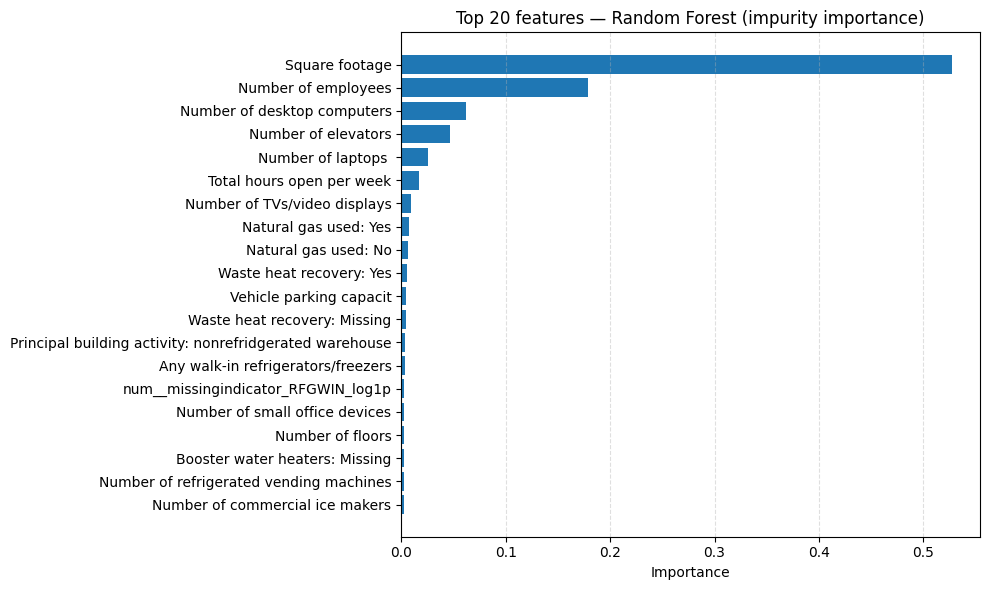

In [15]:
# --- Manual mapping from engineered feature names to CBECS descriptions ---
rf_name_map = {
    "num__SQFT_log1p":      "Square footage",                     # SQFT
    "num__NWKER_log1p":     "Number of employees",               # NWKER
    "num__PCTERMN_log1p":   "Number of desktop computers",       # PCTERMN
    "num__NELVTR_log1p":    "Number of elevators",               # NELVTR
    "num__LAPTPN_log1p":    "Number of laptops ",                 # LAPTPN
    "num__NFLOOR_log1p":    "Number of floors",                  # NFLOOR
    "num__WKHRS_sqrt":      "Total hours open per week",          # WKHRS
    "cat__RFGWI_1.0":       "Any walk-in refrigerators/freezers",        # RFGWI
    "num__RFGWIN_log1p":    "Number of walk-in refrigeration units",   # RFGWIN
    "num__RFGVNN_log1p":    "Number of refrigerated vending machines", # RFGVNN
    "num__RFGICN_log1p":    "Number of commercial ice makers",   # RFGICN
    "num__SMOFFDEVN_log1p": "Number of small office devices",    # SMOFFDEVN
    "num__TVVIDEON_log1p":  "Number of TVs/video displays",      # TVVIDEON
    "num__PKLTN_sqrt":      "Vehicle parking capacit",           # PKLTN
    "cat__NGUSED_1":        "Natural gas used: Yes",                     # NGUSED
    "cat__NGUSED_2":        "Natural gas used: No",                # NGUSED 
    "cat__WHRECOV_2.0":     "Waste heat recovery: Yes",                  # WHRECOV
    "cat__WHRECOV_nan":     "Waste heat recovery: Missing",      # WHRECOV (missing)
    "cat__BOOSTWT_nan":     "Booster water heaters: Missing",    # BOOSTWT
    "cat__PBA_5":           "Principal building activity: nonrefridgerated warehouse",   # PBA
}

# --- Build RF importance DataFrame with pretty labels and plot ---

# Grab preprocessor and RF model from the pipeline
preproc_rf = best_rf_pipe.named_steps["preproc"]
rf         = best_rf_pipe.named_steps["model"]

# Feature names after preprocessing and RF importances
rf_features    = preproc_rf.get_feature_names_out()
rf_importances = rf.feature_importances_

rf_df = (
    pd.DataFrame({"feature": rf_features, "importance": rf_importances})
      .sort_values("importance", ascending=False)
      .head(20)                             # top 20
      .sort_values("importance", ascending=True)  # for nicer barh ordering
)

# Apply human-readable labels where available
rf_df["pretty_feature"] = rf_df["feature"].map(rf_name_map).fillna(rf_df["feature"])

plt.figure(figsize=(10, 6))
plt.barh(rf_df["pretty_feature"], rf_df["importance"])
plt.xlabel("Importance")
plt.title("Top 20 features — Random Forest (impurity importance)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [16]:
# # Test values on the validation set.
# from __future__ import annotations
# import numpy as np
# import pandas as pd
# from sklearn.metrics import r2_score
# from sklearn.linear_model import LinearRegression

# def evaluate_on_validation(
#     X_train, y_train, X_val, y_val,
#     final_lasso,
#     final_rf=None,
#     feature="num__SQFT_log1p",
#     decimals=4,
# ):
#     # --- helpers ---
#     def _col2d(X, feat):
#         # Return a single feature as 2D (n,1) for sklearn; supports DataFrame (by name) and ndarray (by index).
#         import pandas as pd, numpy as np
#         if isinstance(X, pd.DataFrame):
#             if feat not in X.columns:
#                 raise KeyError(f"Column '{feat}' not found in X.")
#             return X[[feat]].to_numpy()
#         X = np.asarray(X)
#         if isinstance(feat, (int, np.integer)):
#             return X[:, [feat]]
#         raise TypeError("For ndarray X, 'feature' must be an int index; for DataFrame X, a column name.")

#     def _metrics(y_true, y_pred):
#         # Compact metric helper to keep logic consistent across models.
#         resid = y_true - y_pred
#         sse = float(np.sum(resid**2))
#         mse = float(sse / len(y_true))
#         r2  = float(r2_score(y_true, y_pred))
#         return r2, sse, mse

#     # --- 1) Baseline mean (fit on train mean, eval on val) ---
#     y_train = np.asarray(y_train).ravel()
#     y_val   = np.asarray(y_val).ravel()
#     mean_val = float(y_train.mean())
#     yhat_mean = np.full_like(y_val, fill_value=mean_val, dtype=float)
#     r2_mean, sse_mean, mse_mean = _metrics(y_val, yhat_mean)

#     # --- 2) One-feature LinearRegression (fit on train, eval on val) ---
#     Xtr_col = _col2d(X_train, feature)
#     Xva_col = _col2d(X_val, feature)
#     lr = LinearRegression().fit(Xtr_col, y_train)
#     yhat_lr = lr.predict(Xva_col)
#     r2_lr, sse_lr, mse_lr = _metrics(y_val, yhat_lr)

#     # --- 3) Final Lasso pipeline (already fit on train), eval on val ---
#     yhat_lasso = final_lasso.predict(X_val)
#     r2_lasso, sse_lasso, mse_lasso = _metrics(y_val, yhat_lasso)

#     # --- 4) Optional: Random Forest pipeline (already fit on train), eval on val ---
#     if final_rf is not None:
#         yhat_rf = final_rf.predict(X_val)
#         r2_rf, sse_rf, mse_rf = _metrics(y_val, yhat_rf)
#     else:
#         r2_rf = sse_rf = mse_rf = None

#     # --- pretty print ---
#     d = decimals
#     print(f"BASELINE mean         : R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={len(y_val)}")
#     print(f"LR[{feature}]         : R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={len(y_val)}  "
#           f"(coef={lr.coef_[0]:.{d}f}, intercept={lr.intercept_:.{d}f})")
#     print(f"Lasso (final pipeline): R2={r2_lasso:.{d}f}  SSE={sse_lasso:.{d}f}  MSE={mse_lasso:.{d}f}  n={len(y_val)}")
#     if final_rf is not None:
#         print(f"RF (final pipeline)   : R2={r2_rf:.{d}f}  SSE={sse_rf:.{d}f}  MSE={mse_rf:.{d}f}  n={len(y_val)}")

#     # --- return a tidy summary ---
#     rows = [
#         {"model": "baseline_mean", "R2": r2_mean,  "SSE": sse_mean,  "MSE": mse_mean},
#         {"model": f"LR[{feature}]", "R2": r2_lr,   "SSE": sse_lr,   "MSE": mse_lr,
#          "coef": float(lr.coef_[0]), "intercept": float(lr.intercept_)},
#         {"model": "lasso_final",    "R2": r2_lasso,"SSE": sse_lasso,"MSE": mse_lasso},
#     ]
#     if final_rf is not None:
#         rows.append({"model": "rf_final", "R2": r2_rf, "SSE": sse_rf, "MSE": mse_rf})

#     summary = pd.DataFrame(rows)
#     return summary

# # ---- Example call ----
# summary_val = evaluate_on_validation(
#     X_train, y_train,
#     X_val, y_val,
#     final_lasso=final_lasso,
#     final_rf=best_rf_pipe,      # your tuned RF pipeline
#     feature="SQFT_log1p"
# )
# print(summary_val)

# Test a quick XGboost to see initial performance

In [17]:
# XGBoost regressor
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="reg:squarederror",
    random_state=1,
    n_jobs=-1,
)

xgb_pipe = Pipeline([
    ("preproc", clone(preproc)),  # reuse your existing preprocessing
    ("model", xgb),
])

# --- Cross-validated performance on training data ---
scoring = "r2"   # or "neg_mean_absolute_error" if you prefer MAE
cv_scores = cross_val_score(xgb_pipe, X_train, y_train, cv=rkf, scoring=scoring, n_jobs=-1)
print(f"XGB (CV) {scoring}: mean={cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Fit on full training set and evaluate on test set ---
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)

resid = y_test - y_pred_xgb
sse  = float(np.sum(resid**2))
mse  = float(sse / len(y_test))
r2   = float(r2_score(y_test, y_pred_xgb))

print(f"[XGB] Test R² = {r2:.4f}")
print(f"[XGB] Test SSE = {sse:.4f}")
print(f"[XGB] Test MSE = {mse:.4f}")

XGB (CV) r2: mean=0.925 ± 0.006
[XGB] Test R² = 0.9362
[XGB] Test SSE = 172.6491
[XGB] Test MSE = 0.2715


In [18]:


# # --- Paths and flags ---
# OUT_DIR = Path("artifacts")
# OUT_DIR.mkdir(exist_ok=True)

# run_tuning_xgb = False  # <-- set to True only when you actually want to re-run Optuna

# # --- CV + scoring setup ---
# cv = rkf if "rkf" in globals() else RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# SCORING = "r2"   # change to "neg_mean_absolute_error" if you prefer MAE


# def objective_xgb(trial):
#     # Hyperparameter search space (narrowed around your good region)
#     n_estimators     = trial.suggest_int("n_estimators", 600, 1400)
#     max_depth        = trial.suggest_int("max_depth", 3, 6)
#     learning_rate    = trial.suggest_float("learning_rate", 0.005, 0.05, log=True)
#     min_child_weight = trial.suggest_int("min_child_weight", 5, 25)
#     subsample        = trial.suggest_float("subsample", 0.4, 0.8)
#     colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0)
#     reg_lambda       = trial.suggest_float("reg_lambda", 0.1, 3.0, log=True)
#     reg_alpha        = trial.suggest_float("reg_alpha", 1e-4, 0.05, log=True)
#     gamma            = trial.suggest_float("gamma", 0.0, 1.0)
    
#     xgb = XGBRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         min_child_weight=min_child_weight,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         reg_lambda=reg_lambda,
#         reg_alpha=reg_alpha,
#         gamma=gamma,
#         objective="reg:squarederror",
#         tree_method="hist",
#         random_state=1,
#         n_jobs=-1,
#     )

#     pipe = Pipeline([
#         ("preproc", clone(preproc)),
#         ("model", xgb),
#     ])

#     scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=SCORING, n_jobs=-1)
#     return scores.mean()


# if run_tuning_xgb:
#     # --- Run Optuna study ---
#     study_xgb = optuna.create_study(
#         direction="maximize",
#         sampler=TPESampler(seed=1)
#     )
#     study_xgb.optimize(objective_xgb, n_trials=200, show_progress_bar=False)

#     print(f"[XGB] Best CV {SCORING}: {study_xgb.best_value:.4f}")
#     print("Best XGB params:")
#     best_p = study_xgb.best_trial.params.copy()
#     for k, v in best_p.items():
#         print(f"  {k}: {v}")

#     # Save best XGB params so you don't have to re-run Optuna later
#     with open(OUT_DIR / "xgb_optuna_best_params.json", "w") as f:
#         json.dump(best_p, f, indent=2)
#     print("Saved best XGB params to", OUT_DIR / "xgb_optuna_best_params.json")

# else:
#     # --- Load previously saved best params ---
#     with open(OUT_DIR / "xgb_optuna_best_params.json", "r") as f:
#         best_p = json.load(f)
#     print("Loaded best XGB params from", OUT_DIR / "xgb_optuna_best_params.json")


# # --- Refit best XGBoost pipeline on full training set and evaluate on test ---
# best_xgb = XGBRegressor(
#     n_estimators=best_p["n_estimators"],
#     max_depth=best_p["max_depth"],
#     learning_rate=best_p["learning_rate"],
#     min_child_weight=best_p["min_child_weight"],
#     subsample=best_p["subsample"],
#     colsample_bytree=best_p["colsample_bytree"],
#     reg_lambda=best_p["reg_lambda"],
#     reg_alpha=best_p["reg_alpha"],
#     gamma=best_p["gamma"],
#     objective="reg:squarederror",
#     tree_method="hist",
#     random_state=1,
#     n_jobs=-1,
# )

# best_xgb_pipe = Pipeline([
#     ("preproc", clone(preproc)),
#     ("model", best_xgb),
# ])

# best_xgb_pipe.fit(X_train, y_train)
# y_pred_xgb = best_xgb_pipe.predict(X_test)

# resid_xgb = y_test - y_pred_xgb
# sse_xgb   = float(np.sum(resid_xgb**2))
# mse_xgb   = float(sse_xgb / len(y_test))
# r2_xgb    = float(r2_score(y_test, y_pred_xgb))

# print(f"[XGB] Test R² = {r2_xgb:.4f}")
# print(f"[XGB] Test SSE = {sse_xgb:.4f}")
# print(f"[XGB] Test MSE = {mse_xgb:.4f}")

# Tune XGBoost with Optuna

In [19]:
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

RUN_XGB_TUNING = False  # <-- flip to True if re-tuning

SCORING = "r2"
cv = rkf  # defined earlier in notebook

def build_xgb_model(params: dict) -> Pipeline:
    xgb = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=1,
        n_jobs=-1,
        **params,
    )
    return Pipeline([
        ("preproc", clone(preproc)),
        ("model", xgb),
    ])

def tune_xgb():
    def objective_xgb(trial):
        # --- refined search space ---
        xgb_params = {
            "n_estimators": trial.suggest_int("n_estimators", 600, 1400),
            "max_depth": trial.suggest_int("max_depth", 3, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 5, 25),
            "subsample": trial.suggest_float("subsample", 0.4, 0.8),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 3.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 0.05, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        }

        pipe = build_xgb_model(xgb_params)
        scores = cross_val_score(
            pipe,
            X_train,
            y_train,
            cv=cv,
            scoring=SCORING,
            n_jobs=-1,
        )
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=1),
    )
    study.optimize(objective_xgb, n_trials=200, show_progress_bar=False)

    best_params = study.best_trial.params
    with open(ARTIFACTS / "xgb_optuna_best_params.json", "w") as f:
        json.dump(best_params, f, indent=2)


    print(f"[XGB] Best CV {SCORING}: {study.best_value:.4f}")
    print("Best params:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

    return best_params

def get_xgb_params(run_tuning: bool = RUN_XGB_TUNING):
    params_path = ARTIFACTS / "xgb_optuna_best_params.json"
    if run_tuning or not params_path.exists():
        print("Running Optuna tuning for XGB...")
        return tune_xgb()
    else:
        print(f"Loading tuned XGB params from {params_path}")
        with open(params_path) as f:
            return json.load(f)


xgb_params = get_xgb_params()
best_xgb_pipe = build_xgb_model(xgb_params)
best_xgb_pipe.fit(X_train, y_train)

Loading tuned XGB params from artifacts/xgb_optuna_best_params.json


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('median_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x31275c5c0>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02330132188797036, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=10, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=-1,
                              num_parallel_tree=None, random_state=1, ...))])

# Examine XGBoost features

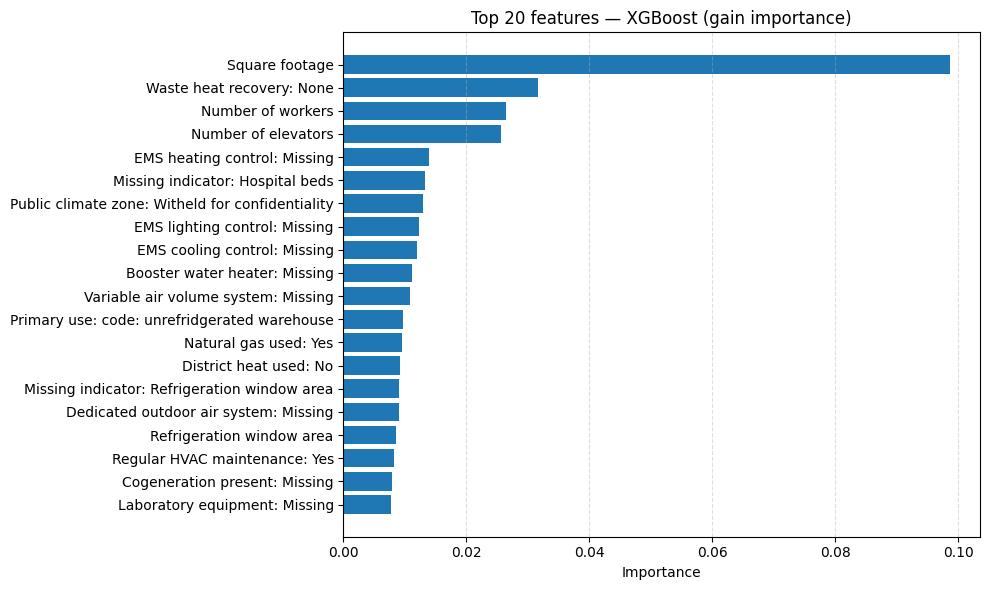

In [20]:
# --- Grab fitted XGBoost and preprocessor from the pipeline ---
xgb_preproc = best_xgb_pipe.named_steps["preproc"]
xgb_model   = best_xgb_pipe.named_steps["model"]

# 1) Get feature names after preprocessing
try:
    xgb_features = xgb_preproc.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn / custom transformers
    xgb_features = []
    for name, trans, cols in xgb_preproc.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if trans == "passthrough":
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            xgb_features.extend([str(c) for c in cols])
        else:
            if hasattr(trans, "get_feature_names_out"):
                base = np.array(cols).astype(str)
                xgb_features.extend(trans.get_feature_names_out(base))
            else:
                if isinstance(cols, (list, np.ndarray)):
                    xgb_features.extend([f"{name}__{c}" for c in cols])
                else:
                    xgb_features.append(f"{name}")

xgb_features = np.asarray(xgb_features)

# 2) XGBoost importances 
xgb_importances = xgb_model.feature_importances_

# --- Manual mapping from encoded feature name -> human-readable label ---
name_map = {
    "num__SQFT_log1p": "Square footage",
    "cat__WHRECOV_2.0": "Waste heat recovery: None",
    "num__NWKER_log1p": "Number of workers",
    "num__NELVTR_log1p": "Number of elevators",
    "cat__EMCSHT_nan": "EMS heating control: Missing",
    "num__missingindicator_HCBED_sqrt": "Missing indicator: Hospital beds",
    "cat__PUBCLIM_7": "Public climate zone: Witheld for confidentiality",
    "cat__EMCSLT_nan": "EMS lighting control: Missing",
    "cat__EMCSCL_nan": "EMS cooling control: Missing",
    "cat__BOOSTWT_nan": "Booster water heater: Missing",
    "cat__VAV_nan": "Variable air volume system: Missing",
    "cat__PBA_5": "Primary use: code: unrefridgerated warehouse",
    "cat__NGUSED_1": "Natural gas used: Yes",
    "cat__DHUSED_2": "District heat used: No",
    "num__missingindicator_RFGWIN_log1p": "Missing indicator: Refrigeration window area",
    "cat__DOAS_nan": "Dedicated outdoor air system: Missing",
    "num__RFGWIN_log1p": "Refrigeration window area",
    "cat__MAINT_1.0": "Regular HVAC maintenance: Yes",
    "cat__COGEN_nan": "Cogeneration present: Missing",
    "cat__LABEQP_nan": "Laboratory equipment: Missing",
}

# 3) Build DataFrame, map names, and plot top 20
xgb_df = (
    pd.DataFrame({"feature": xgb_features, "importance": xgb_importances})
      .sort_values("importance", ascending=False)
      .head(20)
      .sort_values("importance", ascending=True)
)

# Apply manual labels where available
xgb_df["label"] = xgb_df["feature"].map(name_map).fillna(xgb_df["feature"])

plt.figure(figsize=(10, 6))
plt.barh(xgb_df["label"], xgb_df["importance"])
plt.xlabel("Importance")
plt.title("Top 20 features — XGBoost (gain importance)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Residuals vs fitted (diagnostics)

I plot residuals against fitted values to check basic regression assumptions and spot failure modes:
- **Random scatter around 0** suggests the linear mean function is adequate.
- **Curvature** implies unmodeled nonlinearity or interactions.
- **Funnel shape** indicates heteroscedasticity (variance grows/shrinks with ŷ); consider variance-stabilizing transforms or robust models.
- **Vertical bands/outliers** can reflect influential points or segment-specific misspecification.
- Metrics (R², MSE, SSE, n) in the inset anchor the plot to test-set performance.

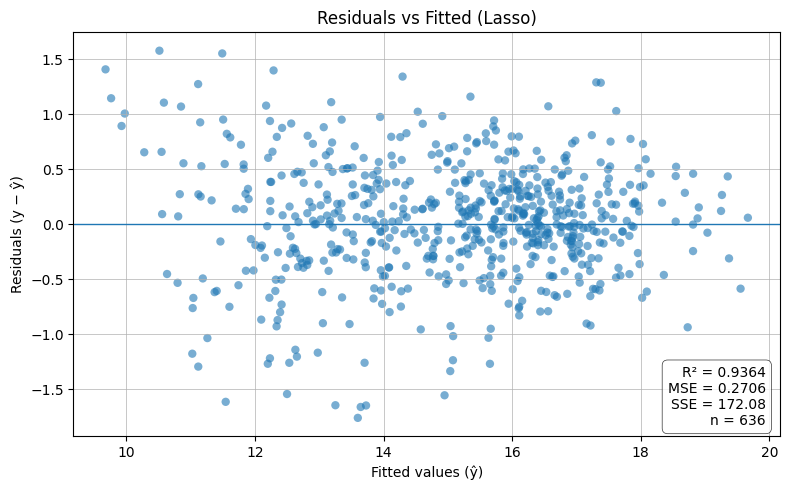

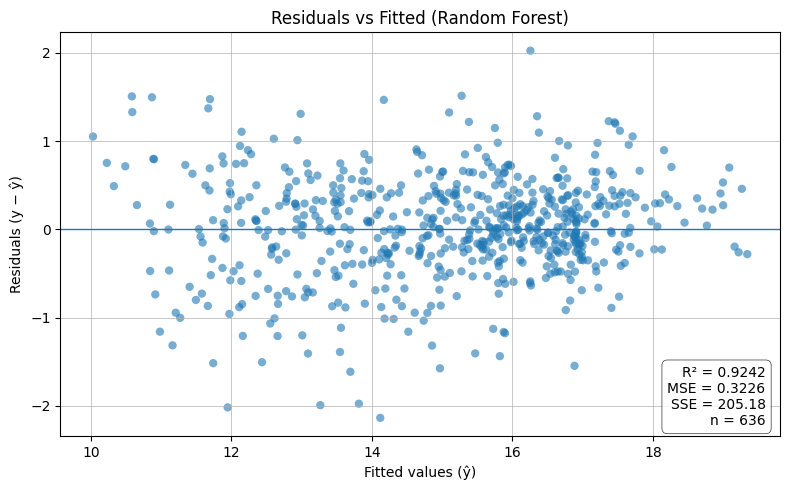

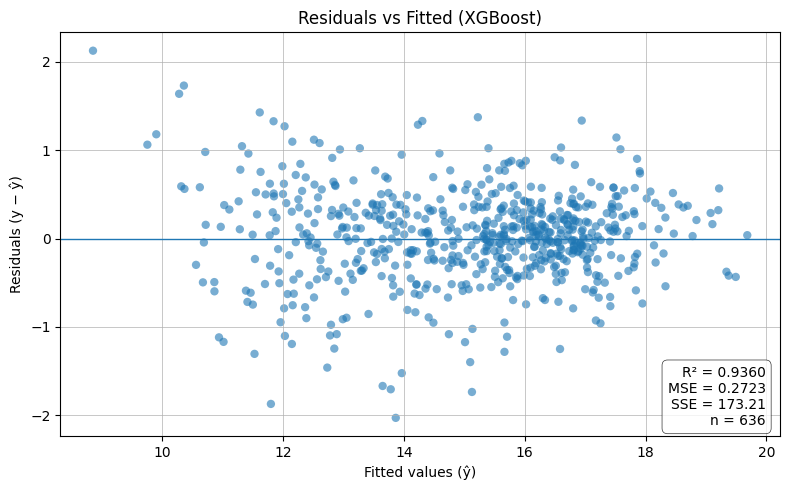

In [21]:
def plot_residuals(model, X_test, y_test, title_suffix):
    # Predict
    y_pred = model.predict(X_test)
    resid  = y_test - y_pred

    # Metrics
    sse = float(np.sum(resid**2))
    mse = float(sse / len(y_test))
    r2  = float(r2_score(y_test, y_pred))

    # Residuals vs fitted: quick visual check for nonlinearity, heteroscedasticity, and outliers
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, resid, alpha=0.6, edgecolor="none")
    plt.axhline(0, linewidth=1)
    plt.xlabel("Fitted values (ŷ)")
    plt.ylabel("Residuals (y − ŷ)")
    plt.title(f"Residuals vs Fitted ({title_suffix})")
    plt.grid(True, linewidth=0.5)

    # Stats box: test-set metrics for context
    text = f"R² = {r2:.4f}\nMSE = {mse:.4f}\nSSE = {sse:.2f}\nn = {len(y_test)}"
    plt.gca().text(
        0.98, 0.02, text,
        transform=plt.gca().transAxes,
        ha="right", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, linewidth=0.5)
    )

    plt.tight_layout()
    plt.show()


# Lasso residuals
plot_residuals(final_lasso, X_test, y_test, title_suffix="Lasso")

# Random Forest residuals
plot_residuals(best_rf_pipe, X_test, y_test, title_suffix="Random Forest")

# XGBoost residuals
plot_residuals(best_xgb_pipe, X_test, y_test, title_suffix="XGBoost")

# Learning curve (MAE) on training data

I plot a learning curve to see how error changes as I increase the number of training examples. I use **MAE** as the metric, repeated K-fold CV for stability, and only the training split (to keep the test set untouched). This helps diagnose whether the model is bias-limited (both curves high and close) or variance-limited (large gap between train and validation curves) and whether adding more data would help.

/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


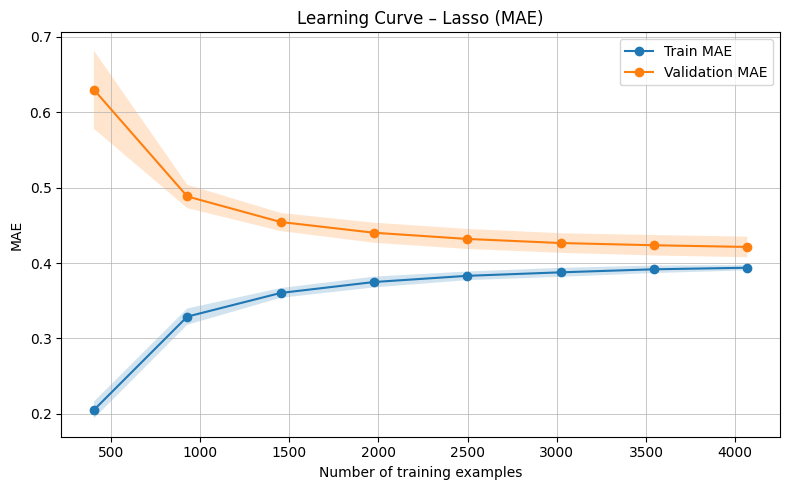

/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


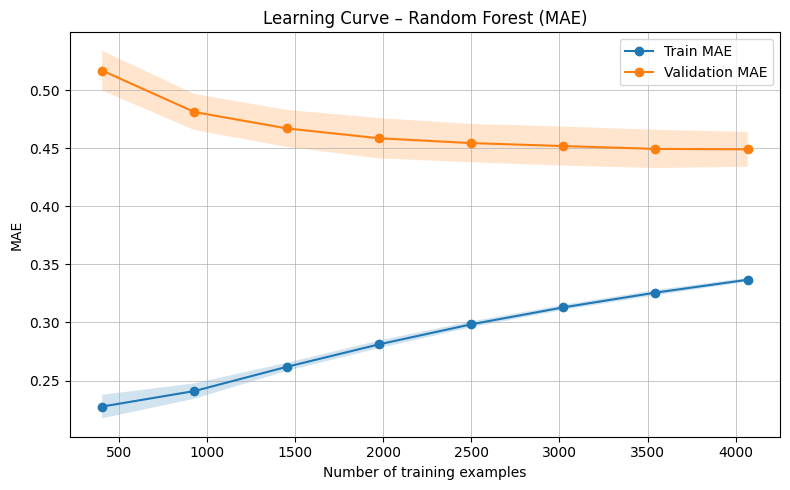

/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/drew/Documents/CBECS_portfolio/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['SLFCNP_PR']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


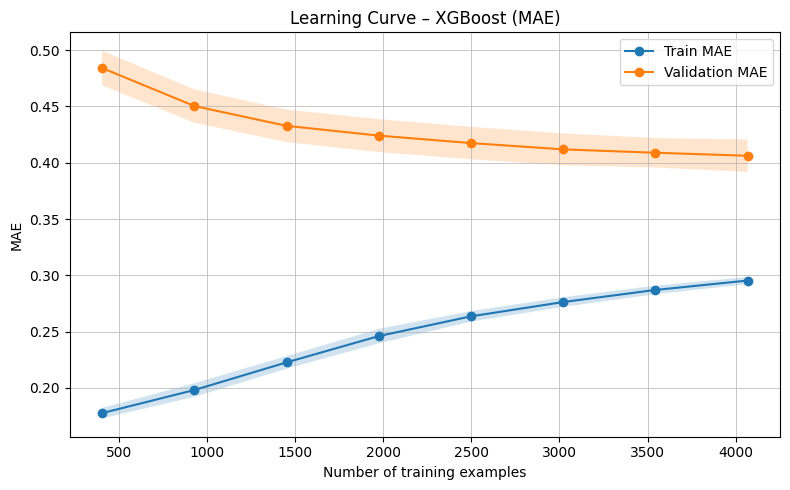

In [23]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def plot_learning_curve_mae(
    estimator,
    X,
    y,
    cv,
    title,
    train_sizes=np.linspace(0.1, 1.0, 8),
):
    sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=mae_scorer,   # negative MAE
        n_jobs=-1,
        shuffle=True,
        random_state=1,
    )

    # Convert from negative MAE to MAE
    train_mae = -train_scores
    val_mae   = -val_scores

    train_mean = train_mae.mean(axis=1)
    train_std  = train_mae.std(axis=1)
    val_mean   = val_mae.mean(axis=1)
    val_std    = val_mae.std(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, train_mean, marker="o", label="Train MAE")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(sizes, val_mean, marker="o", label="Validation MAE")
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.xlabel("Number of training examples")
    plt.ylabel("MAE")
    plt.title(title)
    plt.legend()
    plt.grid(True, linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_learning_curve_mae(
    estimator=final_lasso,
    X=X_train,
    y=y_train,
    cv=rkf,
    title="Learning Curve – Lasso (MAE)",
)

plot_learning_curve_mae(
    estimator=best_rf_pipe,
    X=X_train,
    y=y_train,
    cv=rkf,
    title="Learning Curve – Random Forest (MAE)",
)

plot_learning_curve_mae(
    estimator=best_xgb_pipe,
    X=X_train,
    y=y_train,
    cv=rkf,
    title="Learning Curve – XGBoost (MAE)",
)

# Plot the residual histograms

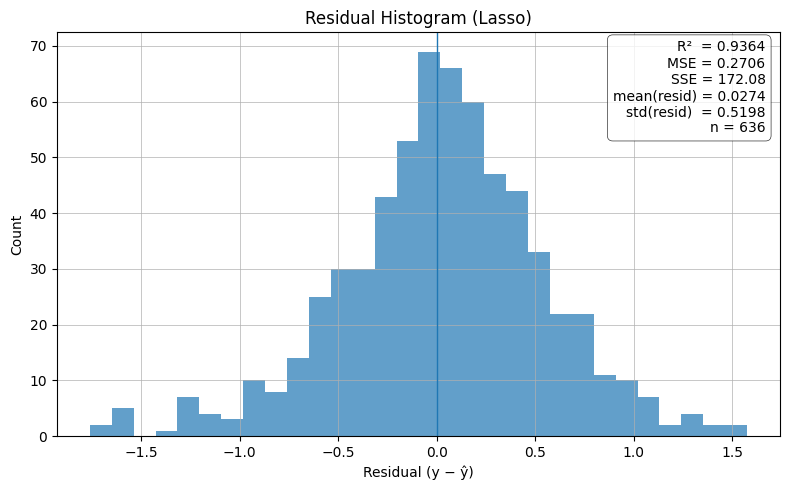

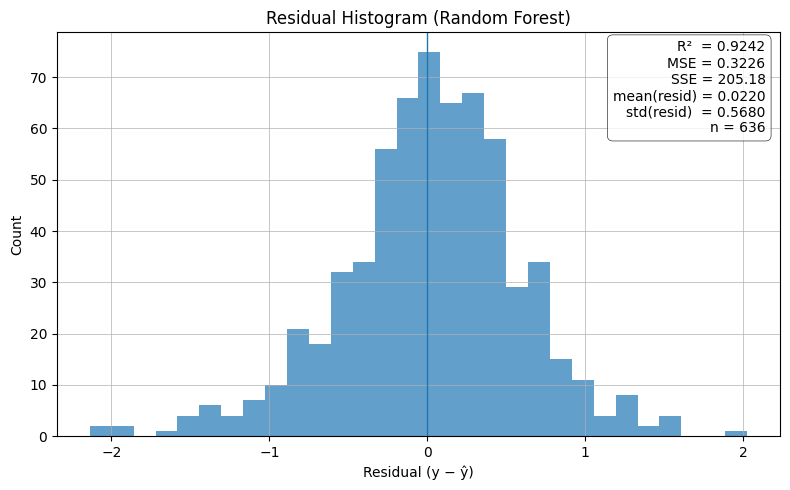

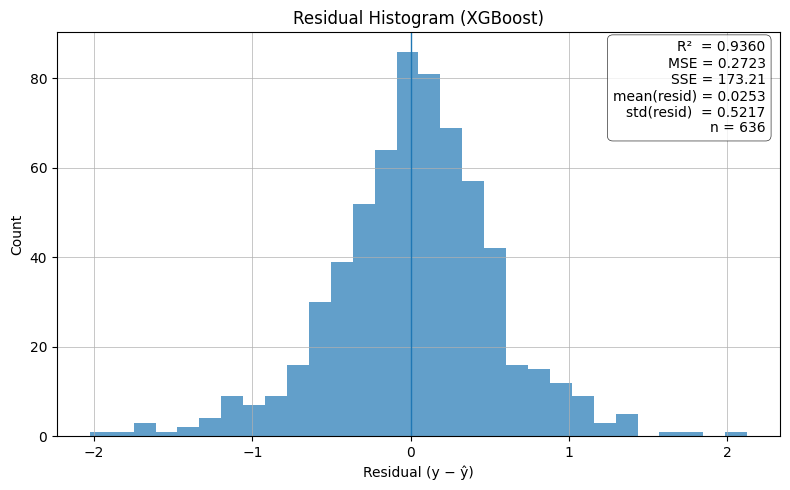

In [24]:
def plot_residual_hist(model, X_test, y_test, title_suffix, bins=30):
    # Predict
    y_pred = model.predict(X_test)
    resid  = y_test - y_pred

    # Metrics
    sse = float(np.sum(resid**2))
    mse = float(sse / len(y_test))
    r2  = float(r2_score(y_test, y_pred))

    plt.figure(figsize=(8, 5))
    plt.hist(resid, bins=bins, alpha=0.7)
    plt.axvline(0, linewidth=1)
    plt.xlabel("Residual (y − ŷ)")
    plt.ylabel("Count")
    plt.title(f"Residual Histogram ({title_suffix})")
    plt.grid(True, linewidth=0.5)

    # Stats box: basic metrics for context
    text = (
        f"R²  = {r2:.4f}\n"
        f"MSE = {mse:.4f}\n"
        f"SSE = {sse:.2f}\n"
        f"mean(resid) = {resid.mean():.4f}\n"
        f"std(resid)  = {resid.std():.4f}\n"
        f"n = {len(y_test)}"
    )
    plt.gca().text(
        0.98, 0.98, text,
        transform=plt.gca().transAxes,
        ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, linewidth=0.5)
    )

    plt.tight_layout()
    plt.show()


# Lasso residual histogram
plot_residual_hist(final_lasso, X_test, y_test, title_suffix="Lasso")

# Random Forest residual histogram
plot_residual_hist(best_rf_pipe, X_test, y_test, title_suffix="Random Forest")

# XGBoost residual histogram
plot_residual_hist(best_xgb_pipe, X_test, y_test, title_suffix="XGBoost")

### Model comparison and final choice

Across all evaluated models, **both regularized linear models and nonlinear tree-based models substantially outperform the baseline** (predicting only the mean) and the simple 1-feature regression using `SQFT_log1p`.

**Summary of findings:**

- **Baseline mean**  
  - R² ≈ 0  
  - Very high SSE/MSE  
  - Serves only as a reference point.

- **1-feature Linear Regression (`SQFT_log1p`)**  
  - R² ≈ 0.82  
  - Captures the dominant size–energy relationship, but misses nonlinear and categorical interactions.

- **Lasso / Elastic Net**  
  - R² ≈ 0.93 on validation  
  - Strong performance with sparse, interpretable coefficients  
  - Highlights key building attributes driving energy use.

- **Random Forest**  
  - R² ≈ 0.92  
  - Nonlinear and interaction-aware  
  - Slightly weaker generalization compared to Lasso and XGBoost.

- **XGBoost (tuned)**  
  - **Highest R² (~0.93+) and lowest SSE/MSE**  
  - Captures subtle nonlinear effects and interaction structures  
  - Most accurate model overall.

---

### **Final Recommendation**

For **primary predictive performance**, I'd likely choose **XGBoost**, as it achieves the strongest validation metrics and lowest error.

However, the **Lasso model** remains valuable as an **interpretable companion model**—it provides a transparent view of which building characteristics matter most for energy consumption, and its performance is close to the tree-based methods despite its simplicity.

Together, **XGBoost for accuracy** and **Lasso for interpretability** form a strong modeling pair for both prediction and explanation.

In [25]:
def evaluate_on_validation(
    X_train, y_train,
    X_val, y_val,
    final_lasso,
    final_rf=None,
    final_xgb=None,
    feature="num__SQFT_log1p",
    decimals=4,
):
    def _col2d(X, feat):
        # Return a single feature as 2D (n,1) for sklearn; supports DataFrame (by name) and ndarray (by index).
        import pandas as pd, numpy as np
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]
        raise TypeError("For ndarray X, 'feature' must be an int index; for DataFrame X, a column name.")

    def _metrics(y_true, y_pred):
        # Compact metric helper to keep logic consistent across models.
        resid = y_true - y_pred
        sse = float(np.sum(resid**2))
        mse = float(sse / len(y_true))
        r2  = float(r2_score(y_true, y_pred))
        return r2, sse, mse

    # --- 1) Baseline mean (fit on train mean, eval on val) ---
    y_train = np.asarray(y_train).ravel()
    y_val   = np.asarray(y_val).ravel()
    mean_val = float(y_train.mean())
    yhat_mean = np.full_like(y_val, fill_value=mean_val, dtype=float)
    r2_mean, sse_mean, mse_mean = _metrics(y_val, yhat_mean)

    # --- 2) One-feature LinearRegression (fit on train, eval on val) ---
    Xtr_col = _col2d(X_train, feature)
    Xva_col = _col2d(X_val, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)
    yhat_lr = lr.predict(Xva_col)
    r2_lr, sse_lr, mse_lr = _metrics(y_val, yhat_lr)

    # --- 3) Final Lasso pipeline (already fit on train), eval on val ---
    yhat_lasso = final_lasso.predict(X_val)
    r2_lasso, sse_lasso, mse_lasso = _metrics(y_val, yhat_lasso)

    # --- 4) Optional: Random Forest pipeline (already fit on train), eval on val ---
    if final_rf is not None:
        yhat_rf = final_rf.predict(X_val)
        r2_rf, sse_rf, mse_rf = _metrics(y_val, yhat_rf)
    else:
        r2_rf = sse_rf = mse_rf = None

    # --- 5) Optional: XGBoost pipeline (already fit on train), eval on val ---
    if final_xgb is not None:
        yhat_xgb = final_xgb.predict(X_val)
        r2_xgb, sse_xgb, mse_xgb = _metrics(y_val, yhat_xgb)
    else:
        r2_xgb = sse_xgb = mse_xgb = None

    # --- pretty print ---
    d = decimals
    print(f"BASELINE mean         : R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={len(y_val)}")
    print(f"LR[{feature}]         : R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={len(y_val)}  "
          f"(coef={lr.coef_[0]:.{d}f}, intercept={lr.intercept_:.{d}f})")
    print(f"Lasso (final pipeline): R2={r2_lasso:.{d}f}  SSE={sse_lasso:.{d}f}  MSE={mse_lasso:.{d}f}  n={len(y_val)}")
    if final_rf is not None:
        print(f"RF (final pipeline)   : R2={r2_rf:.{d}f}  SSE={sse_rf:.{d}f}  MSE={mse_rf:.{d}f}  n={len(y_val)}")
    if final_xgb is not None:
        print(f"XGB (final pipeline)  : R2={r2_xgb:.{d}f}  SSE={sse_xgb:.{d}f}  MSE={mse_xgb:.{d}f}  n={len(y_val)}")

    # --- return a tidy summary ---
    rows = [
        {"model": "baseline_mean", "R2": r2_mean,  "SSE": sse_mean,  "MSE": mse_mean},
        {"model": f"LR[{feature}]", "R2": r2_lr,   "SSE": sse_lr,   "MSE": mse_lr,
         "coef": float(lr.coef_[0]), "intercept": float(lr.intercept_)},
        {"model": "lasso_final",    "R2": r2_lasso,"SSE": sse_lasso,"MSE": mse_lasso},
    ]
    if final_rf is not None:
        rows.append({"model": "rf_final",  "R2": r2_rf,  "SSE": sse_rf,  "MSE": mse_rf})
    if final_xgb is not None:
        rows.append({"model": "xgb_final", "R2": r2_xgb, "SSE": sse_xgb, "MSE": mse_xgb})

    summary = pd.DataFrame(rows)
    return summary

# ---- Example call ----
summary_val = evaluate_on_validation(
    X_train, y_train,
    X_val, y_val,
    final_lasso=final_lasso,
    final_rf=best_rf_pipe,       
    final_xgb=best_xgb_pipe,     
    feature="SQFT_log1p",
)
print(summary_val)

BASELINE mean         : R2=-0.0005  SSE=3016.0919  MSE=4.7423  n=636
LR[SQFT_log1p]         : R2=0.8209  SSE=539.8148  MSE=0.8488  n=636  (coef=1.0556, intercept=3.4813)
Lasso (final pipeline): R2=0.9293  SSE=212.9853  MSE=0.3349  n=636
RF (final pipeline)   : R2=0.9214  SSE=236.9738  MSE=0.3726  n=636
XGB (final pipeline)  : R2=0.9326  SSE=203.3020  MSE=0.3197  n=636
            model        R2          SSE       MSE     coef  intercept
0   baseline_mean -0.000549  3016.091939  4.742283      NaN        NaN
1  LR[SQFT_log1p]  0.820924   539.814836  0.848765  1.05556   3.481269
2     lasso_final  0.929345   212.985306  0.334883      NaN        NaN
3        rf_final  0.921387   236.973783  0.372600      NaN        NaN
4       xgb_final  0.932557   203.301955  0.319657      NaN        NaN


### Feature Importance Summary Across Models

Using Lasso, Random Forest, and XGBoost, a consistent set of building attributes emerges as the primary drivers of **site energy consumption**.

---

### **1. Building size dominates**

Across all models, **square footage** (`SQFT_log1p`) is by far the strongest predictor. I suppose this isn't surprising—more square footage means more area to heat, or more area for machinery, etc.

- **Lasso:** largest absolute coefficient  
- **Random Forest:** highest impurity importance  
- **XGBoost:** top gain-based importance  

> **Bigger buildings use more energy**

---

### **2. Occupancy and usage intensity**

All models highlight variables reflecting how intensively the building is used, including:

- Number of **workers/occupants**
- Total **operating hours per week**
- Counts of **desktops, laptops, TVs/video displays**

> Buildings that are open longer or support more plug loads consume noticeably more energy.

---

### **3. HVAC systems, controls, and equipment**

Variables related to heating/cooling system type, controls, and equipment presence rank highly:

- Presence/absence of advanced HVAC components  
- Ventilation and air distribution equipment  
- Features with high missingness that encode real structural variation (e.g., “not applicable” categories)

> These features capture significant differences in mechanical system efficiency and operation.

---

### **4. Primary Building Activity (PBA Codes 4, 5, 6)**

Using corrected meanings:

| **PBA Code** | **Meaning**                    |
|--------------|--------------------------------|
| **4**        | Laboratory                     |
| **5**        | Non-refrigerated warehouse     |
| **6**        | Food sales (e.g., grocery)     |

**Why they matter:**

- **Laboratories (PBA 4)** are extreme energy users due to ventilation, fume hoods, and specialized equipment.  
- **Food sales (PBA 6)** require heavy refrigeration, lighting, and long operating hours.  
- **Non-refrigerated warehouses (PBA 5)** tend to consume far less energy than most other building types, making them a strong negative predictor.

These categories consistently appear near the top of all models’ importance lists.


---
### **5. Missingness Itself Can Be Predictive**  
Flags like **BOOSTWT_nan** or **ENRGYPLN_nan** are meaningful in tree-based models.  
This reflects structural patterns in the survey data:  
- Buildings with missing mechanical information often share similar characteristics (e.g., simpler systems, smaller footprints).  
- All tested models models can leverage this information even when the missingness is not explicitly informative.

---

### **Overall Interpretation**

These features collectively explain the majority of variation in site energy use, and their **consistency across models** provides confidence in the overall interpretation.  
The dominant themes—**size**, **building activity type**, and **mechanical system configuration**—align with domain expectations from building science and energy modeling.

---

## **A Note on Scope and Future Directions**

This project is intentionally framed as a **toy problem** designed to demonstrate applied understanding of:

- Data preprocessing and feature engineering  
- Regularization (Lasso / Elastic Net)  
- Tree-based modeling (Random Forest, XGBoost)  
- Hyperparameter tuning with Optuna  
- Model evaluation on held-out validation sets  
- Interpreting feature importance across model classes  

Although the predictive results are strong, the modeling target—**total site energy use**—is heavily dominated by building size.  
For deeper insights into *efficiency* rather than *consumption*, an interesting next step would be:

### **→ Model energy intensity (Energy per Square Foot)**  
This target would help uncover what makes buildings *efficient* or *inefficient*, instead of simply *large* or *small*.  
It is likely to surface a different set of meaningful predictors and may give more actionable insights for energy management and policy.


### **Overall conclusion**

Despite using different modeling mechanisms, the three models agree on the major drivers:

1. **Building size**  
2. **Usage intensity / occupancy patterns**  
3. **HVAC systems and mechanical characteristics**  
4. **Building-type indicators (PBA)**  

These features collectively explain the majority of variation in site energy use, and their consistency across models provides confidence in the overall interpretation.